## Set up

## Load Dataset

In [3]:
import pandas as pd
data = pd.read_csv(r'../resources/processed_data.csv')

In [4]:
print(data.head())
data.shape

                                    Processed_Review sentiment
0  one review mention watch oz episod hook right ...  positive
1  wonder littl product film techniqu unassum old...  positive
2  thought wonder way spend time hot summer weeke...  positive
3  basic famili littl boy jake think zombi closet...  negative
4  petter mattei love time money visual stun film...  positive


(49582, 2)

### TFIDF

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Chuyển dữ liệu sang đặc trưng số sử dụng TF-IDF
tfidf = TfidfVectorizer(max_features=10000) 

# Chia data thành các tập train và test
X = tfidf.fit_transform(data['Processed_Review']).toarray()
# Chuyển sentiment positive thành 1 và negative thành 0
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['sentiment'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train.shape



(34707, 10000)

## Multi-layer Perceptron

In [6]:
input_dim = X_train.shape[1]

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

# Define the MLP model
MLP = Sequential([
    Dense(128, activation='relu', input_dim=input_dim),  # Input layer
    BatchNormalization(),  # Batch normalization
    Dropout(0.4),          # Dropout for regularization

    #Dense(64, activation='relu'),  # Hidden layer
    #BatchNormalization(),          # Batch normalization
    #Dropout(0.4),                  # Dropout for regularization

    Dense(1, activation='sigmoid')  # Output layer (2 classes) [0] and [1], not one-hot encoding
])

# Compile the model
MLP.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
print(MLP.summary())

c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     1,280,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,769 (4.89 MB)

 Trainable params: 1,280,513 (4.88 MB)

 Non-trainable params: 256 (1.00 KB)

None


In [7]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Model training
MLP_history = MLP.fit(
    X_train, y_train,
    batch_size=128,
    epochs=20,
    verbose=1,
    validation_split=0.2, # Dành một phần dữ liệu train để làm validation
    callbacks=[early_stopping]
)

Epoch 1/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8194 - loss: 0.3887 - val_accuracy: 0.8807 - val_loss: 0.5556
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9444 - loss: 0.1564 - val_accuracy: 0.8812 - val_loss: 0.3562
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9732 - loss: 0.0844 - val_accuracy: 0.8806 - val_loss: 0.2989
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9892 - loss: 0.0408 - val_accuracy: 0.8794 - val_loss: 0.3821
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9946 - loss: 0.0233 - val_accuracy: 0.8740 - val_loss: 0.4667
Epoch 6/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9977 - loss: 0.0118 - val_accuracy: 0.8711 - val_loss: 0.5149
Epoch 7/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9989 - loss: 0.0076 - val_accuracy: 0.8753 - val_loss: 0.5431
Epoch 8/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9992 - loss: 0.0058 - val_accu

In [8]:
from sklearn.metrics import confusion_matrix

# Evaluate on test data
test_loss, test_accuracy = MLP.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Classification report
y_pred = (MLP.predict(X_test) > 0.5).astype("int32").flatten()

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8724 - loss: 0.3047
Test Loss: 0.3113, Test Accuracy: 0.8708
465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

    negative       0.88      0.86      0.87      7461
    positive       0.86      0.88      0.87      7414

    accuracy                           0.87     14875
   macro avg       0.87      0.87      0.87     14875
weighted avg       0.87      0.87      0.87     14875



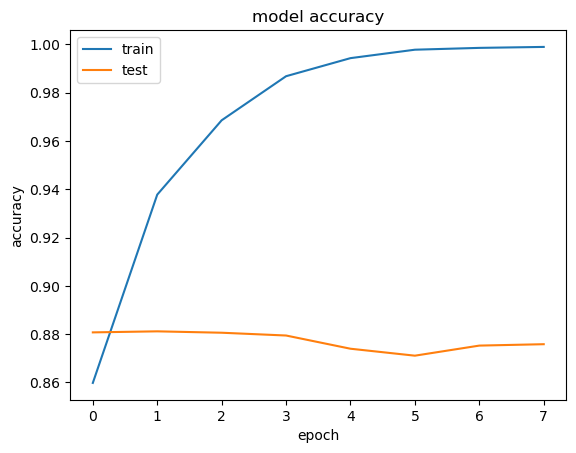

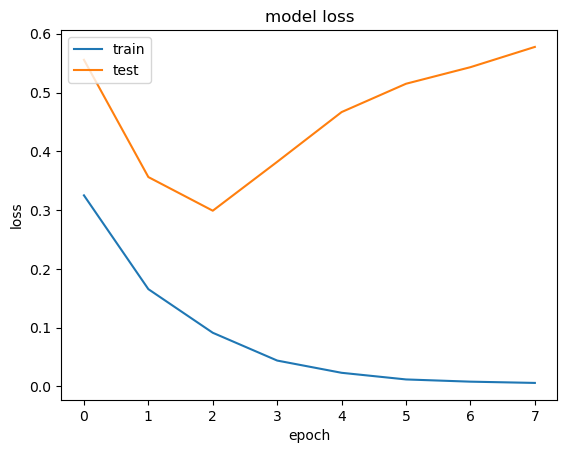

In [9]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(MLP_history.history['accuracy'])
plt.plot(MLP_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(MLP_history.history['loss'])
plt.plot(MLP_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

y_test shape: (14875,)
ypred shape: (14875,)


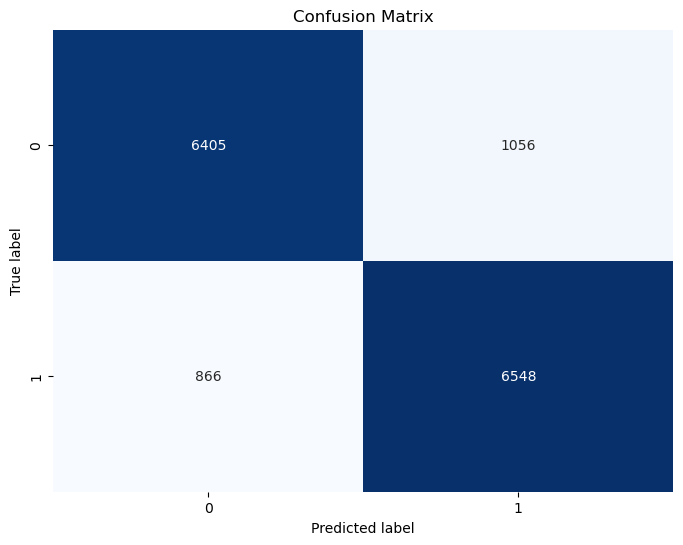

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Kiểm tra kích thước
print("y_test shape:", y_test.shape)
print("ypred shape:", y_pred.shape)

# Tính toán Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Vẽ Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

### GloVe

## Bidirectional Long Short-Term Memory Network 

In [29]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv(r'../resources/processed_data.csv')

In [30]:
X2 = []
sentences = list(data['Processed_Review'])
for sen in sentences:
    X2.append(sen)
    
# chuyển đổi sentiment thành dạng số
label_encoder = LabelEncoder()
y2 = label_encoder.fit_transform(data['sentiment'])

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42)


In [31]:
import numpy as np

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, BatchNormalization
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding
from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences

In [32]:
# Lớp embedding của keras cho phép chúng ta chuyển đổi các từ thành các vector số
# Phương thức fit_on_text sẽ tạo ra một từ điển từ các từ trong tập dữ liệu
# Phương thức texts_to_sequences sẽ chuyển đổi các câu thành các chuỗi số

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train2)

X_train2 = word_tokenizer.texts_to_sequences(X_train2)
X_test2 = word_tokenizer.texts_to_sequences(X_test2)

In [33]:
import io
import json

# Saving
tokenizer_json = word_tokenizer.to_json()
with io.open('../resources/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [34]:
# Thêm 1 để lưu trữ kích thước cho các từ mà không có embedding từ trước

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

60410

In [35]:
# Để đảm bảo rằng tất cả các câu có cùng độ dài, chúng ta sẽ sử dụng phương thức pad_sequences của keras để thêm các giá trị 0 vào các câu ngắn hơn

maxlen = 200

X_train2 = pad_sequences(X_train2, padding='post', maxlen=maxlen)
X_test2 = pad_sequences(X_test2, padding='post', maxlen=maxlen)

In [36]:
# Sử dụng các vector từ GloVe để tạo ra một ma trận embedding cho các từ trong tập dữ liệu

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('../resources/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [37]:
# Tạo ma trận embedding có 100 cột 
# Chứa các vector 100 chiều của GloVe cho tất cả các từ trong tập dữ liệu

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix.shape

(60410, 100)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, LayerNormalization

# Redesigned BiLSTM Model
BiLSTM = Sequential([
    Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False),
    
     # First BiLSTM Layer
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),  
    
    # Second BiLSTM Layer
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),  
    
    # Conv1D Layer
    Conv1D(100, 5, activation='relu'),
    
    # GlobalMaxPooling1D Layer
    GlobalMaxPooling1D(),
    # Dense Layers
    Dense(64, activation='relu'),  # Fully connected layer
    Dropout(0.3),                  # Dropout for regularization
    Dense(1, activation='sigmoid') # Output layer for binary classification
])

# Compile the Model
BiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
BiLSTM.summary()

c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │     6,041,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,041,000 (23.04 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,041,000 (23.04 MB)

In [45]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

BiLSTM_history = BiLSTM.fit(X_train2, y_train2,
                            batch_size=128,
                            epochs=15,
                            verbose=1,
                            validation_split=0.2,
                            callbacks=[early_stopping])

Epoch 1/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 578s 3s/step - accuracy: 0.6349 - loss: 0.6278 - val_accuracy: 0.7737 - val_loss: 0.4874
Epoch 2/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - accuracy: 0.7405 - loss: 0.5243 - val_accuracy: 0.7872 - val_loss: 0.4482
Epoch 3/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step - accuracy: 0.7727 - loss: 0.4762 - val_accuracy: 0.8054 - val_loss: 0.4199
Epoch 4/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.7974 - loss: 0.4448 - val_accuracy: 0.8299 - val_loss: 0.3775
Epoch 5/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 373s 2s/step - accuracy: 0.8062 - loss: 0.4236 - val_accuracy: 0.8414 - val_loss: 0.3669
Epoch 6/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.8195 - loss: 0.3973 - val_accuracy: 0.8450 - val_loss: 0.3529
Epoch 7/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.8333 - loss: 0.3757 - val_accuracy: 0.8390 - val_loss: 0.3681
Epoch 8/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.8395 - loss: 0.3629 - val_accu

In [46]:
from sklearn.preprocessing import LabelEncoder

# Evaluate on test data
test_loss, test_accuracy = BiLSTM.evaluate(X_test2, y_test2, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Classification report
# Classification report
y_pred2 = (BiLSTM.predict(X_test2) > 0.5).astype("int32").flatten()

print(classification_report(y_test2, y_pred2, target_names=label_encoder.classes_))


465/465 ━━━━━━━━━━━━━━━━━━━━ 41s 87ms/step - accuracy: 0.8618 - loss: 0.3199
Test Loss: 0.3208, Test Accuracy: 0.8614
465/465 ━━━━━━━━━━━━━━━━━━━━ 45s 95ms/step
              precision    recall  f1-score   support

    negative       0.88      0.84      0.86      7404
    positive       0.85      0.88      0.86      7471

    accuracy                           0.86     14875
   macro avg       0.86      0.86      0.86     14875
weighted avg       0.86      0.86      0.86     14875



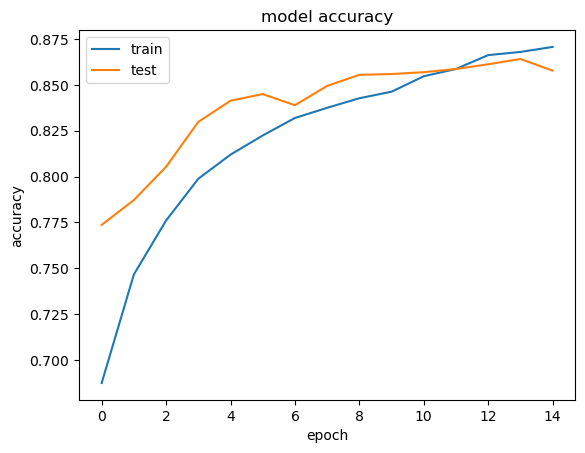

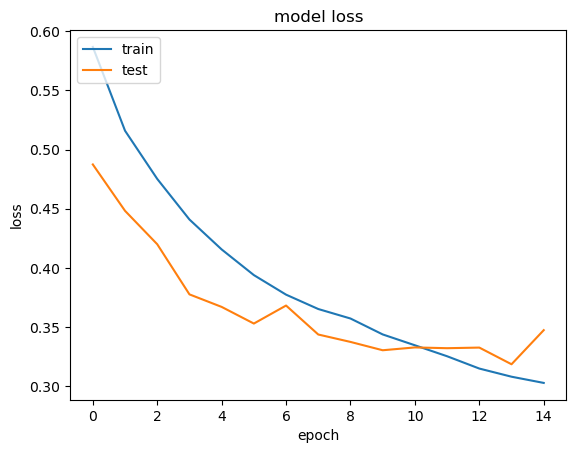

In [47]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(BiLSTM_history.history['accuracy'])
plt.plot(BiLSTM_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(BiLSTM_history.history['loss'])
plt.plot(BiLSTM_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

y_test shape: (14875,)
y_pred shape: (14875,)


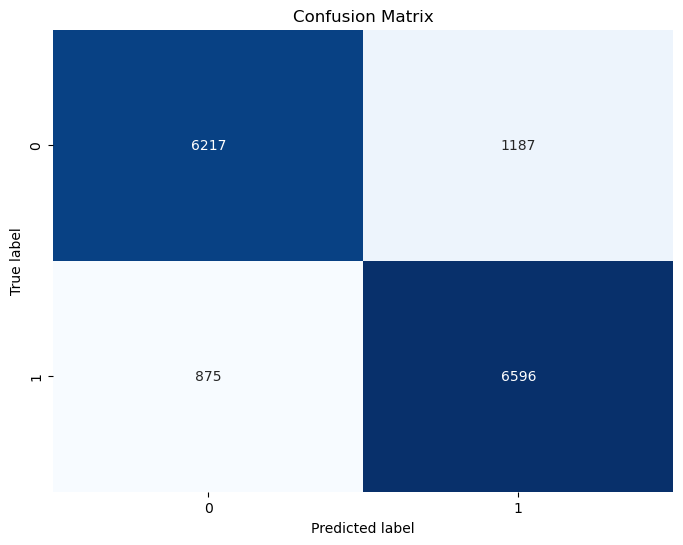

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Kiểm tra kích thước
print("y_test shape:", y_test2.shape)
print("y_pred shape:", y_pred2.shape)

# Tính toán Confusion Matrix
cf_matrix = confusion_matrix(y_test2, y_pred2)

# Vẽ Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

### Multi-Layer Perceptron

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization,Flatten
from keras.optimizers import Adam

# Define the MLP model
MLP = Sequential([
    Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=True),
    Flatten(),
    Dense(128, activation='relu', input_dim=input_dim),  # Input layer
    BatchNormalization(),  # Batch normalization
    Dropout(0.4),          # Dropout for regularization

    #Dense(64, activation='relu'),  # Hidden layer
    #BatchNormalization(),          # Batch normalization
    #Dropout(0.4),                  # Dropout for regularization

    Dense(1, activation='sigmoid')  # Output layer (2 classes) [0] and [1], not one-hot encoding
])

# Compile the model
MLP.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
print(MLP.summary())

c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     6,041,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,041,000 (23.04 MB)

 Trainable params: 6,041,000 (23.04 MB)

 Non-trainable params: 0 (0.00 B)

None


In [36]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

MLP_history = MLP.fit(X_train2, y_train2,
                            batch_size=128,
                            epochs=10,
                            verbose=1,
                            validation_split=0.2,
                            callbacks=[early_stopping])

Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.6387 - loss: 0.7057 - val_accuracy: 0.7789 - val_loss: 0.4693
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.8812 - loss: 0.2953 - val_accuracy: 0.8227 - val_loss: 0.4093
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - accuracy: 0.9518 - loss: 0.1398 - val_accuracy: 0.8271 - val_loss: 0.4750
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.9820 - loss: 0.0596 - val_accuracy: 0.8235 - val_loss: 0.5665
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.9948 - loss: 0.0241 - val_accuracy: 0.8254 - val_loss: 0.6691
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.9983 - loss: 0.0103 - val_accuracy: 0.8279 - val_loss: 0.7345
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.9994 - loss: 0.0057 - val_accuracy: 0.8264 - val_loss: 0.7354


In [37]:
from sklearn.preprocessing import LabelEncoder

# Evaluate on test data
test_loss, test_accuracy = MLP.evaluate(X_test2, y_test2, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Classification report
# Classification report
y_pred2 = (BiLSTM.predict(X_test2) > 0.5).astype("int32").flatten()

print(classification_report(y_test2, y_pred2, target_names=label_encoder.classes_))


465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8222 - loss: 0.4162
Test Loss: 0.4092, Test Accuracy: 0.8251
465/465 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step
              precision    recall  f1-score   support

    negative       0.78      0.78      0.78      7404
    positive       0.78      0.78      0.78      7471

    accuracy                           0.78     14875
   macro avg       0.78      0.78      0.78     14875
weighted avg       0.78      0.78      0.78     14875



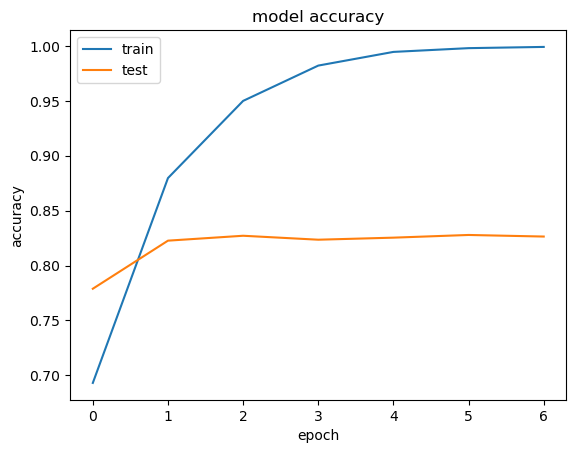

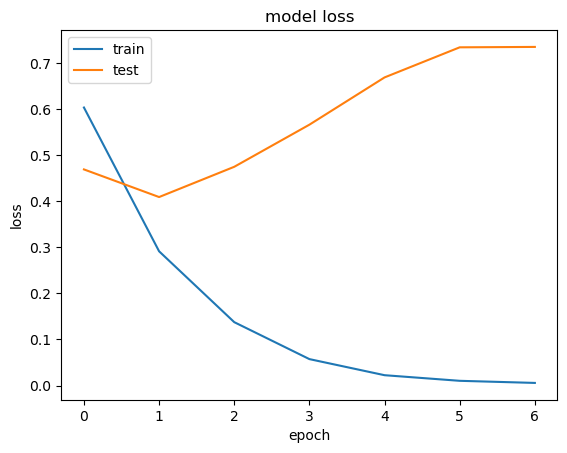

In [38]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(MLP_history.history['accuracy'])
plt.plot(MLP_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(MLP_history.history['loss'])
plt.plot(MLP_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

y_test shape: (14875,)
y_pred shape: (14875,)


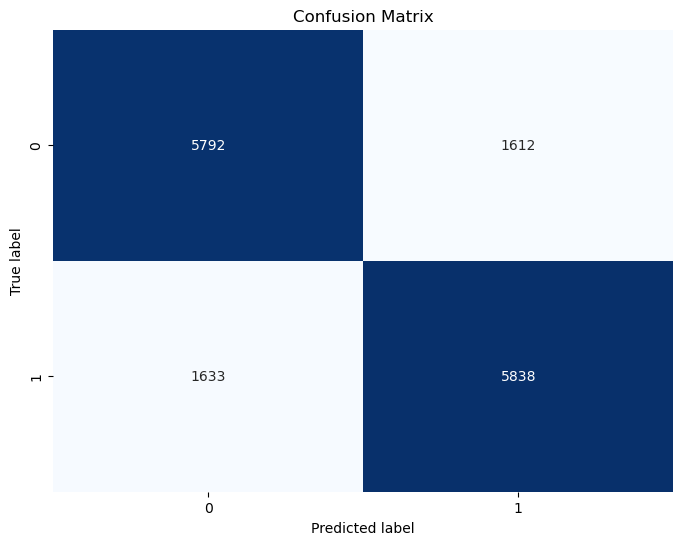

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Kiểm tra kích thước
print("y_test shape:", y_test2.shape)
print("y_pred shape:", y_pred2.shape)

# Tính toán Confusion Matrix
cf_matrix = confusion_matrix(y_test2, y_pred2)

# Vẽ Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()